# Fiducial intervals

Alternative to point estimation: given an unknown quantity $\tau$

- provide an interval $I$ likely containing $\tau$
- and quantiy this likelyhood

## Prerequisites

- Gaussian distribution
- Sample mean, sample variance, and their properties
- (minor) basic python knowledge

## A first example

$$\{ X_1, \dots, X_n\} \text{ sample from } X\sim N(\mu, \sigma)$$

$$\bar X = \frac{1}{n}\sum_{i=1}^n X_i \sim N\left(\mu, \frac{\sigma}{\sqrt{n}}\right)$$

$$Z = \frac{\bar X - \mu}{\frac{\sigma}{\sqrt{n}}} \sim N(0, 1)$$

Fixed $\alpha$, find $z$ such that

$$\mathrm P(|Z|<z) = \alpha $$

In [155]:
%matplotlib inline

from __future__ import print_function

import scipy.stats as st
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import widgets, interact
from IPython.display import display, clear_output

def ci_graph(conf):
    Z = st.norm()
    q = Z.ppf((1+conf)/2)
    xs = np.arange(-q, q+.01, .01)
    plt.plot(xs, Z.pdf(xs))
    left_tail = np.arange(-3, -q+.01, .01)
    right_tail = np.arange(q, 3, .01)
    plt.fill_between(right_tail, 0, Z.pdf(right_tail), facecolor='lightblue')
    plt.fill_between(left_tail, 0, Z.pdf(left_tail), facecolor='lightblue')
    plt.title('$z = {:.2f}$'.format(q))
    plt.text(q+(3-q)/2, Z.pdf(q), r'$\frac{1-\alpha}{2}$', fontsize=25, horizontalalignment='center')
    plt.text(-q-(3-q)/2, Z.pdf(q), r'$\frac{1-\alpha}{2}$', fontsize=25, horizontalalignment='center')
    plt.text(0, .15, r'$\alpha$', fontsize=25, horizontalalignment='center')
    plt.show()

rangeSlider = widgets.FloatSlider(
    value = .95,
    min = .1,
    max = .99,
    step = .01,
    description = 'Confidence',
    continuous_update = True
)

interact(ci_graph, conf=rangeSlider);

interactive(children=(FloatSlider(value=0.95, description='Confidence', max=0.99, min=0.1, step=0.01), Output()), _dom_classes=('widget-interact',))

Let $\chi_p = \Phi^{-1}(p)$ denote the $p$ quantile of $Z$

The answer is

$$ z = \chi_{1-\frac{1-\alpha}{2}} = \chi_{\frac{1+\alpha}{2}} $$

Some reference values:

In [2]:
def HTML_with_style(df, style=None, random_id=None):
    from IPython.display import HTML
    import numpy as np
    import re

    df_html = df.to_html()

    if random_id is None:
        random_id = 'id%d' % np.random.choice(np.arange(1000000))

    if style is None:
        style = """
        <style>
            table#{random_id} {{color: blue}}
        </style>
        """.format(random_id=random_id)
    else:
        new_style = []
        s = re.sub(r'</?style>', '', style).strip()
        for line in s.split('\n'):
                line = line.strip()
                if not re.match(r'^table', line):
                    line = re.sub(r'^', 'table ', line)
                new_style.append(line)
        new_style = ['<style>'] + new_style + ['</style>']

        style = re.sub(r'table(#\S+)?',
                       'table#%s' % random_id, '\n'.join(new_style))

    df_html = re.sub(r'<table', r'<table id=%s ' % random_id, df_html)

    return HTML(style + df_html)

style = """
<style>
    table tr :first-child{display: none;}
</style>
"""

Z = st.norm()
HTML_with_style(pd.DataFrame([('{:.2f}'.format(alpha),
  '{:.2f}'.format(Z.ppf((1+alpha)/2))) for alpha in np.arange(.5, 1, .05)],
            columns=['alpha', 'z']),
                style)

,alpha,z
0,0.50,0.67
1,0.55,0.76
2,0.60,0.84
3,0.65,0.93
4,0.70,1.04
5,0.75,1.15
6,0.80,1.28
7,0.85,1.44
8,0.90,1.64
9,0.95,1.96


Thus

$$\mathrm P(-\chi_{\frac{1+\alpha}{2}} < Z < \chi_{\frac{1+\alpha}{2}}) = 1 - \alpha $$

In [26]:
def inner_ci_graph(conf):
    Z = st.norm()
    q = Z.ppf((1+conf)/2)
    xs = np.arange(-q, q+.01, .01)
    left_tail = np.arange(-3, -q+.01, .01)
    right_tail = np.arange(q, 3, .01)
    plt.plot(right_tail, Z.pdf(right_tail), c='b')
    plt.plot(left_tail, Z.pdf(left_tail), c='b')
    plt.fill_between(xs, 0, Z.pdf(xs), facecolor='lightblue')
    plt.title('$P({:.2f} < Z < {:.2f}) = {:.2f}$'.format(-q, q, conf), fontsize=25)
    plt.show()

rangeSlider = widgets.FloatSlider(
    value = .95,
    min = .1,
    max = .99,
    step = .01,
    description = 'Confidence',
    continuous_update = True
)

interact(inner_ci_graph, conf=rangeSlider);

interactive(children=(FloatSlider(value=0.95, description='Confidence', max=0.99, min=0.1, step=0.01), Output()), _dom_classes=('widget-interact',))

But

$$Z = \frac{\bar X - \mu}{\frac{\sigma}{\sqrt{n}}} \sim N(0, 1)$$

so

$$\mathrm P\left(
    -\chi_{\frac{1+\alpha}{2}} < Z < \chi_{\frac{1+\alpha}{2}}
  \right) = 
  \mathrm P\left(
    \bar X -\chi_{\frac{1+\alpha}{2}} \frac{\sigma}{\sqrt{n}} <
    \mu < \bar X + \chi_{\frac{1+\alpha}{2}} \frac{\sigma}{\sqrt{n}}
  \right) $$

Summing up

$$\mathrm P\left(
    \bar X -\chi_{\frac{1+\alpha}{2}} \frac{\sigma}{\sqrt{n}} <
    \mu < \bar X + \chi_{\frac{1+\alpha}{2}} \frac{\sigma}{\sqrt{n}}
  \right) = \alpha $$
  
Thus

$$\left(\bar X -\chi_{\frac{1+\alpha}{2}} \frac{\sigma}{\sqrt{n}},
       \bar X + \chi_{\frac{1+\alpha}{2}} \frac{\sigma}{\sqrt{n}}\right)$$

is a _confidence interval_ for $\mu$

Let's replace $\alpha$ by $1 - \delta$:

$$ \mathrm P \left(|Z| < \chi_{\frac{1+\alpha}{2}} \right) = \alpha $$

translates to

$$ \mathrm P \left(|Z| < \chi_{1-\frac{\delta}{2}} \right) = 1-\delta $$

and $\chi_{1-\frac{\delta}{2}} = - \chi_{\frac{\delta}{2}}$, thus

$$ \mathrm P\left(
     \bar X +\chi_{\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}} <
     \mu < \bar X - \chi_{\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}
   \right) = 1-\delta $$
  
Formally speaking

$$ \left(
     \bar X +\chi_{\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}},
     \bar X - \chi_{\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}
   \right) = 1-\delta $$

is a _confidence interval_ for $\mu = \mathcal E(X)$:

- $1-\delta$: _confidence_ of the interval,
- $\delta$: _confidence level_ of the interval.

Let's synthesize some data and play around. Pretend these constitute a normally-distributed population of martian heigth, measured in a suitable unit:

In [74]:
mu = 1200
sigma = 37
n = 1000
X = st.norm(mu, sigma)
population = pd.DataFrame(X.rvs(n), columns=['Martian height'])
population.head()

,Martian height
0,1234.877356
1,1201.003564
2,1179.351141
3,1297.584249
4,1185.416008


For sake of simplicity, let's also build a function computing generic confidence intervals for the mean of a gaussian variable.

In [61]:
def ci_mu_norm(sigma, delta, sample):
    Z = st.norm()
    x_bar = sample.mean()
    chi = Z.ppf(delta/2)
    n = len(sample)
    confidence_interval = (x_bar + chi * sigma / math.sqrt(n),
                           x_bar - chi * sigma / math.sqrt(n))

    return confidence_interval

Just to check out that everything works, we can sample 30 martians and see what happens.

In [75]:
sample = population['Martian height'].sample(30)
ci = ci_mu_norm(sigma, 0.05, sample)
print(ci)

(1180.832629117599, 1207.312702444613)


I've also defined a `show_sample_and_ci` function showing sample, confidence interval, and mean to be estimated (click the three dots here below if you are curioius).

In [102]:
def show_sample_and_ci(sample, ci, mu):
    n = len(sample)
    plt.plot(sample, [0]*n, 'o', ms=4, alpha=0.5)
    plt.plot((sample.min(), sample.max()), (0,0))
    plt.plot(ci, (0, 0), c='b', linewidth=4)
    plt.plot(2*[ci[0]], (-.01, .01), c='b')
    plt.plot(2*[ci[1]], (-.01, .01), c='b')
    plt.plot(2*[mu], (-.05, .05), c='r')
    plt.ylim(-.2, .2)
    plt.xlim(1150, 1250)
    plt.show()

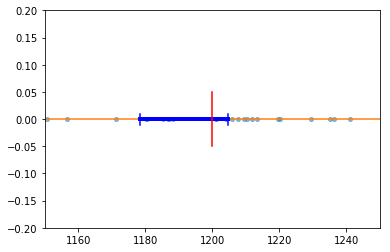

In [103]:
show_sample_and_ci(sample, ci, mu)

In [104]:
ci[0] <= mu <= ci[1]

True

What happens if we repeatedly sample and build a confidence interval?

In [160]:
btn = widgets.Button(description="Once again!")
out = widgets.Output()

def sample_and_compute(b):
    sample = population['Martian height'].sample(30)
    ci = ci_mu_norm(sigma, 0.05, sample)
    with out:
        clear_output()
        show_sample_and_ci(sample, ci, mu)

btn.on_click(sample_and_compute)
sample_and_compute(btn)
widgets.VBox([btn, out])

VBox(children=(Button(description='Once again!', style=ButtonStyle()), Output()))

We can now give a frequentistic interpretatation of the event

$$\bar X -\chi_{\frac{1+\alpha}{2}} \frac{\sigma}{\sqrt{n}} <
    \mu < \bar X + \chi_{\frac{1+\alpha}{2}} \frac{\sigma}{\sqrt{n}}$$

In [147]:
for _ in range(100):
    sample = population['Martian height'].sample(30)
    ci = ci_mu_norm(sigma, 0.05, sample)
    if not ci[0] <= mu <= ci[1]:
        print(ci)

(1172.4074434055453, 1198.8875167325593)
(1207.6370129117993, 1234.1170862388133)


Thus $\delta$ represents the average number of times, in a long run, that the confidence interval does not contain the parameter to be inferred.

Advantage of the interval-based estimate over the point-based one:

- the interval length gives an idea of the indetermination,
- it obviously depends on the distribution under study and on sample size.

In [163]:
def ci_vs_sample_size(n):
    sample = population['Martian height'].sample(n)
    ci = ci_mu_norm(sigma, 0.05, sample)
    show_sample_and_ci(sample, ci, mu)

sizeSlider = widgets.IntSlider(
    value = 30,
    min = 10,
    max = 205,
    step = 5,
    description = 'Sample size',
    continuous_update = True
)

interact(ci_vs_sample_size, n=sizeSlider);

interactive(children=(IntSlider(value=30, description='Sample size', max=205, min=10, step=5), Output()), _dom_classes=('widget-interact',))

In a real-world scenario $\sigma$ is not known. Thus, instead of

$$\frac{\bar X - \mu}{\frac{\sigma}{\sqrt{n}}}$$

use

$$\frac{\bar X - \mu}{\frac{S}{\sqrt{n}}},$$

$S$ being the sample standard deviation, defined by

$$
S^2 = \frac{1}{n-1} \sum_{i=1}^n \left( X_i - \bar X \right)^2
$$

Is the resulting statistic still normal?

Short answer: no.

In [165]:
def t_stat(sample):
    x_bar = sample.mean()
    s = sample.std()
    return x_bar / s * len(sample)**0.5

Z = st.norm()
n = 5000
samples = np.split(Z.rvs(4*n), n)
t_vals = map(t_stat, samples)

import statsmodels.api as sm

ecdf = sm.distributions.ECDF(t_vals)
x = np.arange(-4, 4, 0.1)
y = ecdf(x)
plt.step(x, y)
plt.plot(x, Z.cdf(x))
plt.show()

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
import sta

In [ ]:
def t_graph(n):
    T = st.t(n)
    Z = st.norm()
    xs = np.arange(-4, 4, 0.1)
    plt.plot(xs, T.pdf(xs))
    plt.plot(xs, Z.pdf(xs), alpha=0.4, c='b', linewidth=3)
    plt.ylim(0, 0.4)
    plt.show()

interact(t_graph, n=widgets.IntSlider(
    value = 4,
    min = 1,
    max = 30,
    description = 'Degrees of freedom',
    continuous_update = True
));